In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

folder_name = "/content/drive/MyDrive/dataset"
os.makedirs(folder_name, exist_ok=True)

!unzip "/content/drive/MyDrive/dataset.zip" -d "/content/drive/MyDrive/dataset"


Archive:  /content/drive/MyDrive/dataset.zip
replace /content/drive/MyDrive/dataset/label_colors.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/dataset/label_colors.txt  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1007).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1019).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1024).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1026).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1037).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1038).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1042).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1044).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1047).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1049).jpg  
  inflating: /content/drive/MyDrive/dataset/test/images/Oil (1050

Import libraries

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


print("Libraries imported successfully")



Libraries imported successfully


Check Dataset and count files.

In [4]:
dataset_path = "/content/drive/MyDrive/dataset"

def load_dataset(split):
    image_dir = os.path.join(dataset_path, split, "images")
    mask_dir  = os.path.join(dataset_path, split, "masks")

    image_files = [
        f for f in glob(os.path.join(image_dir, "*"))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    mask_files = [
        f for f in glob(os.path.join(mask_dir, "*"))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    image_map = {
        os.path.splitext(os.path.basename(f))[0]: f
        for f in image_files
    }

    mask_map = {
        os.path.splitext(os.path.basename(f))[0]: f
        for f in mask_files
    }

    common_keys = sorted(image_map.keys() & mask_map.keys())

    assert len(common_keys) > 0, f"No matching image-mask pairs in {split}"

    images = [image_map[k] for k in common_keys]
    masks  = [mask_map[k]  for k in common_keys]

    return images, masks


train_images, train_masks = load_dataset("train")
val_images, val_masks     = load_dataset("val")
test_images, test_masks   = load_dataset("test")

print(f"Train: {len(train_images)} images, {len(train_masks)} masks")
print(f"Validation: {len(val_images)} images, {len(val_masks)} masks")
print(f"Test: {len(test_images)} images, {len(test_masks)} masks")


Train: 811 images, 811 masks
Validation: 203 images, 203 masks
Test: 254 images, 254 masks


Shows sample image & mask

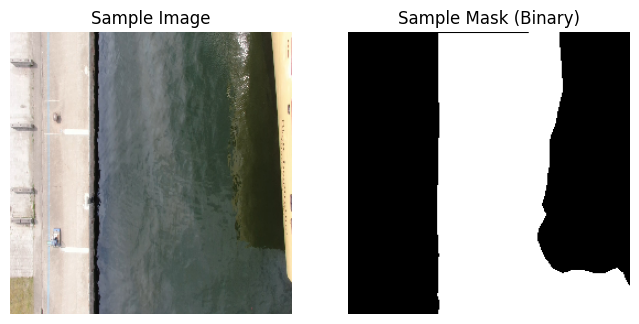

In [6]:
import random

IMG_SIZE = 256
idx = random.randint(0, len(train_images) - 1)

sample_img = cv2.imread(train_images[idx])
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE))
sample_img = sample_img / 255.0

sample_mask = cv2.imread(train_masks[idx], 0)

sample_mask = cv2.resize(
    sample_mask,
    (IMG_SIZE, IMG_SIZE),
    interpolation=cv2.INTER_NEAREST
)

bin_mask = (sample_mask == 90).astype(np.float32)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Sample Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(bin_mask, cmap="gray")
plt.title("Sample Mask (Binary)")
plt.axis("off")

plt.show()

Preprocessing Function (Resize + normalize)

In [42]:
def preprocess_image(img_path, mask_path):
    # ----- IMAGE -----
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    # ----- MASK -----
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # soft mask instead of hard binary
    mask = np.where(mask == 90, 1.0, 0.1).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img, mask

print("Preprocessing function ready")

Preprocessing function ready


Data Augmentation Example

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


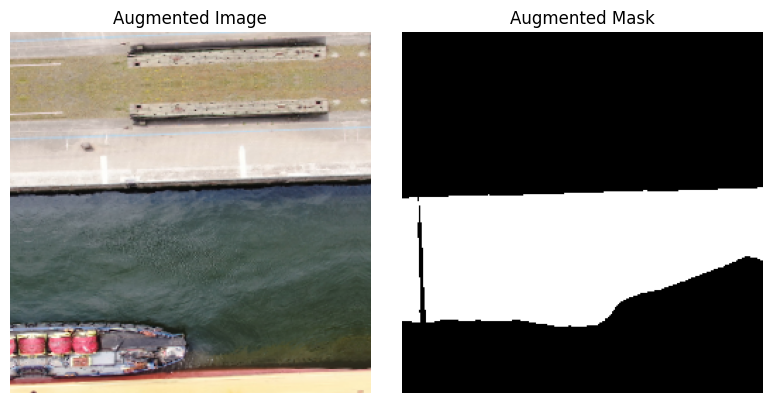

In [8]:
IMG_SIZE = 256
OIL_VALUE = 90

# --------- AUGMENTATION PIPELINE (for OIL images only) ----------
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=15,
        interpolation=cv2.INTER_LINEAR,
        mask_interpolation=cv2.INTER_NEAREST,
        border_mode=cv2.BORDER_REFLECT_101,
        p=0.5
    ),

    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3)
])

# --------- CHECK IF MASK HAS OIL ----------
def has_oil(mask, min_pixels=500):
    return np.sum(mask == OIL_VALUE) > min_pixels

# --------- AUGMENT FUNCTION ----------
def augment_example(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # apply augmentation ONLY if oil present
    if has_oil(mask):
        augmented = transform(image=img, mask=mask)
        img, mask = augmented["image"], augmented["mask"]

    img = img.astype(np.float32) / 255.0

    # soft mask (imbalance-aware)
    mask = np.where(mask == OIL_VALUE, 1.0, 0.1).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img, mask


# --------- VISUAL EXAMPLE ----------
idx = random.randint(0, len(train_images) - 1)

img, mask = augment_example(train_images[idx], train_masks[idx])

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Augmented Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Augmented Mask")
plt.imshow(mask.squeeze(), cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


Custom Data Generator

In [9]:
BATCH_SIZE = 4
IMG_SIZE = 256
def data_generator(img_paths, mask_paths, batch_size, augment=False):
    idxs = np.arange(len(img_paths))
    while True:
        np.random.shuffle(idxs)
        for i in range(0, len(idxs), batch_size):
            batch_idxs = idxs[i:i+batch_size]
            imgs, masks = [], []
            for j in batch_idxs:
                if augment:
                    img, mask = augment_example(img_paths[j], mask_paths[j])
                else:
                    img, mask = preprocess_image(img_paths[j], mask_paths[j])
                imgs.append(img)
                masks.append(mask)
            yield np.array(imgs, dtype=np.float32), np.array(masks, dtype=np.float32)

# ---------------- GENERATORS ----------------
train_gen = data_generator(train_images, train_masks, BATCH_SIZE, augment=True)
val_gen   = data_generator(val_images, val_masks, BATCH_SIZE, augment=False)
test_gen  = data_generator(test_images, test_masks, BATCH_SIZE, augment=False)


# ---------------- SANITY CHECK ----------------
x, y = next(train_gen)
print("Batch shapes:")
print("Images:", x.shape)
print("Masks :", y.shape)
print("Mask unique values:", np.unique(y))


Batch shapes:
Images: (4, 256, 256, 3)
Masks : (4, 256, 256, 1)
Mask unique values: [0.1 1. ]


Build the U-Net Model

In [10]:
def conv_block(x, filters, dropout=False):
    x = layers.Conv2D(filters, 3, padding="same",
                      kernel_initializer="he_normal", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same",
                      kernel_initializer="he_normal", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if dropout:
        x = layers.Dropout(0.3)(x)
    return x


def build_unet(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_size)

    # -------- Encoder --------
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128, dropout=True)
    p3 = layers.MaxPooling2D()(c3)

    # -------- Bottleneck --------
    bn = conv_block(p3, 256, dropout=True)

    # -------- Decoder --------
    u1 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(bn)
    u1 = layers.Concatenate()([u1, c3])
    c4 = conv_block(u1, 128)

    u2 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = conv_block(u2, 64)

    u3 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = conv_block(u3, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c6)

    return models.Model(inputs, outputs)


model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 1,929,825 (7.36 MB)

 Trainable params: 1,927,009 (7.35 MB)

 Non-trainable params: 2,816 (11.00 KB)

Loss Function (Dice + BCE) + IoU Metric

In [15]:
# ---------------- Dice Loss ----------------
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    return 1 - (2. * intersection + smooth) / (union + smooth)


# ---------------- Weighted BCE ----------------
def weighted_bce(y_true, y_pred):
    oil_weight = 4.0
    non_oil_weight = 1.0

    loss = -(
        oil_weight * y_true * tf.math.log(y_pred + 1e-7) +
        non_oil_weight * (1 - y_true) * tf.math.log(1 - y_pred + 1e-7)
    )
    return tf.reduce_mean(loss)


# ---------------- Total Loss ----------------
def total_loss(y_true, y_pred):
    return weighted_bce(y_true, y_pred) + dice_loss(y_true, y_pred)


# ---------------- IoU Metric ----------------
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return intersection / (union + 1e-6)


# ---------------- Pixel Accuracy ----------------
def pixel_accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true > 0.5, tf.float32)

    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))


# ---------------- Oil Pixel Accuracy ----------------
def oil_pixel_accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true > 0.5, tf.float32)

    oil_pixels = tf.reduce_sum(y_true)
    correct_oil = tf.reduce_sum(y_true * tf.cast(tf.equal(y_true, y_pred), tf.float32))

    return tf.where(
        oil_pixels > 0,
        correct_oil / (oil_pixels + 1e-6),
        0.0
    )


Compile

In [16]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=total_loss,
    metrics=[
        tf.keras.metrics.MeanMetricWrapper(iou_metric, name="iou"),
        tf.keras.metrics.MeanMetricWrapper(pixel_accuracy, name="pixel_accuracy"),
        tf.keras.metrics.MeanMetricWrapper(oil_pixel_accuracy, name="oil_pixel_accuracy")
    ]
)



Callbacks & Training

In [17]:
train_steps = int(np.ceil(len(train_images) * 2 / BATCH_SIZE))  # oil oversampling
val_steps   = int(np.ceil(len(val_images) / BATCH_SIZE))

callbacks = [
    ModelCheckpoint(
        "unet_oil_spill_best.h5",
        monitor="val_iou",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_iou",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        mode="max",
        verbose=1
    ),
    EarlyStopping(
        monitor="val_iou",
        patience=5,
        mode="max",
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=30,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks
)



Epoch 1/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou: 0.5474 - loss: 1.3963 - oil_pixel_accuracy: 0.9505 - pixel_accuracy: 0.7457
Epoch 1: val_iou improved from -inf to 0.58856, saving model to unet_oil_spill_best.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 150s 332ms/step - iou: 0.5474 - loss: 1.3962 - oil_pixel_accuracy: 0.9505 - pixel_accuracy: 0.7456 - val_iou: 0.5886 - val_loss: 1.2255 - val_oil_pixel_accuracy: 0.9914 - val_pixel_accuracy: 0.7678 - learning_rate: 1.0000e-04
Epoch 2/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - iou: 0.5478 - loss: 1.3403 - oil_pixel_accuracy: 0.9602 - pixel_accuracy: 0.7518
Epoch 2: val_iou improved from 0.58856 to 0.65403, saving model to unet_oil_spill_best.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 121s 299ms/step - iou: 0.5479 - loss: 1.3402 - oil_pixel_accuracy: 0.9603 - pixel_accuracy: 0.7519 - val_iou: 0.6540 - val_loss: 1.1848 - val_oil_pixel_accuracy: 0.9549 - val_pixel_accuracy: 0.8345 - learning_rate: 1.0000e-04
Epoch 3/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - iou: 0.5726 - loss: 1.2891 - oil_pixel_accuracy: 0.9674 - pixel_accuracy: 0.7712
Epoch 3: val_iou improved from 0.65403 to 0.66002, saving model to unet_oil_spill_best.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 124s 307ms/step - iou: 0.5726 - loss: 1.2891 - oil_pixel_accuracy: 0.9674 - pixel_accuracy: 0.7713 - val_iou: 0.6600 - val_loss: 1.1361 - val_oil_pixel_accuracy: 0.9724 - val_pixel_accuracy: 0.8230 - learning_rate: 1.0000e-04
Epoch 4/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - iou: 0.5965 - loss: 1.2637 - oil_pixel_accuracy: 0.9687 - pixel_accuracy: 0.7891
Epoch 4: val_iou did not improve from 0.66002
406/406 ━━━━━━━━━━━━━━━━━━━━ 139s 343ms/step - iou: 0.5965 - loss: 1.2637 - oil_pixel_accuracy: 0.9687 - pixel_accuracy: 0.7891 - val_iou: 0.6520 - val_loss: 1.1191 - val_oil_pixel_accuracy: 0.9911 - val_pixel_accuracy: 0.8101 - learning_rate: 1.0000e-04
Epoch 5/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - iou: 0.5842 - loss: 1.2711 - oil_pixel_accuracy: 0.9666 - pixel_accuracy: 0.7905
Epoch 5: val_iou improved from 0.66002 to 0.66311, saving model to unet_oil_spill_best.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 120s 296ms/step - iou: 0.5843 - loss: 1.2711 - oil_pixel_accuracy: 0.9666 - pixel_accuracy: 0.7905 - val_iou: 0.6631 - val_loss: 1.1016 - val_oil_pixel_accuracy: 0.9908 - val_pixel_accuracy: 0.8283 - learning_rate: 1.0000e-04
Epoch 6/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - iou: 0.6118 - loss: 1.2471 - oil_pixel_accuracy: 0.9774 - pixel_accuracy: 0.8122
Epoch 6: val_iou improved from 0.66311 to 0.66398, saving model to unet_oil_spill_best.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 138s 341ms/step - iou: 0.6118 - loss: 1.2470 - oil_pixel_accuracy: 0.9774 - pixel_accuracy: 0.8123 - val_iou: 0.6640 - val_loss: 1.1685 - val_oil_pixel_accuracy: 0.9862 - val_pixel_accuracy: 0.8286 - learning_rate: 1.0000e-04
Epoch 7/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - iou: 0.6443 - loss: 1.1994 - oil_pixel_accuracy: 0.9759 - pixel_accuracy: 0.8331
Epoch 7: val_iou improved from 0.66398 to 0.71569, saving model to unet_oil_spill_best.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 118s 290ms/step - iou: 0.6443 - loss: 1.1994 - oil_pixel_accuracy: 0.9759 - pixel_accuracy: 0.8331 - val_iou: 0.7157 - val_loss: 1.1040 - val_oil_pixel_accuracy: 0.9707 - val_pixel_accuracy: 0.8631 - learning_rate: 1.0000e-04
Epoch 8/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - iou: 0.6622 - loss: 1.1674 - oil_pixel_accuracy: 0.9809 - pixel_accuracy: 0.8450
Epoch 8: val_iou improved from 0.71569 to 0.75152, saving model to unet_oil_spill_best.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 118s 290ms/step - iou: 0.6622 - loss: 1.1674 - oil_pixel_accuracy: 0.9809 - pixel_accuracy: 0.8449 - val_iou: 0.7515 - val_loss: 1.1073 - val_oil_pixel_accuracy: 0.9785 - val_pixel_accuracy: 0.8798 - learning_rate: 1.0000e-04
Epoch 9/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - iou: 0.6331 - loss: 1.2080 - oil_pixel_accuracy: 0.9762 - pixel_accuracy: 0.8274
Epoch 9: val_iou did not improve from 0.75152
406/406 ━━━━━━━━━━━━━━━━━━━━ 116s 286ms/step - iou: 0.6331 - loss: 1.2079 - oil_pixel_accuracy: 0.9762 - pixel_accuracy: 0.8275 - val_iou: 0.7417 - val_loss: 1.1590 - val_oil_pixel_accuracy: 0.9464 - val_pixel_accuracy: 0.8819 - learning_rate: 1.0000e-04
Epoch 10/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - iou: 0.6544 - loss: 1.1809 - oil_pixel_accuracy: 0.9708 - pixel_accuracy: 0.8416
Epoch 10: val_iou did not improve from 0.75152
406/406 ━━━━━━━━━━━━━━━━━━━━ 117s 289ms/step - iou: 0.6544 - loss: 1.1809 - oil_pixel_accuracy: 0.9708 - pixel_accuracy: 0

406/406 ━━━━━━━━━━━━━━━━━━━━ 118s 291ms/step - iou: 0.6971 - loss: 1.1277 - oil_pixel_accuracy: 0.9826 - pixel_accuracy: 0.8674 - val_iou: 0.7618 - val_loss: 1.1587 - val_oil_pixel_accuracy: 0.9456 - val_pixel_accuracy: 0.9004 - learning_rate: 5.0000e-05
Epoch 14/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - iou: 0.6872 - loss: 1.1385 - oil_pixel_accuracy: 0.9802 - pixel_accuracy: 0.8626
Epoch 14: val_iou did not improve from 0.76176
406/406 ━━━━━━━━━━━━━━━━━━━━ 116s 285ms/step - iou: 0.6872 - loss: 1.1384 - oil_pixel_accuracy: 0.9802 - pixel_accuracy: 0.8626 - val_iou: 0.7604 - val_loss: 1.1655 - val_oil_pixel_accuracy: 0.9306 - val_pixel_accuracy: 0.8992 - learning_rate: 5.0000e-05
Epoch 15/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - iou: 0.6795 - loss: 1.1510 - oil_pixel_accuracy: 0.9727 - pixel_accuracy: 0.8564
Epoch 15: val_iou did not improve from 0.76176
406/406 ━━━━━━━━━━━━━━━━━━━━ 115s 283ms/step - iou: 0.6795 - loss: 1.1510 - oil_pixel_accuracy: 0.9728 - pixel_accuracy:

406/406 ━━━━━━━━━━━━━━━━━━━━ 117s 290ms/step - iou: 0.6971 - loss: 1.1259 - oil_pixel_accuracy: 0.9798 - pixel_accuracy: 0.8708 - val_iou: 0.7998 - val_loss: 1.0568 - val_oil_pixel_accuracy: 0.9691 - val_pixel_accuracy: 0.9104 - learning_rate: 5.0000e-05
Epoch 17/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - iou: 0.7033 - loss: 1.1126 - oil_pixel_accuracy: 0.9820 - pixel_accuracy: 0.8728
Epoch 17: val_iou did not improve from 0.79984
406/406 ━━━━━━━━━━━━━━━━━━━━ 115s 284ms/step - iou: 0.7033 - loss: 1.1126 - oil_pixel_accuracy: 0.9820 - pixel_accuracy: 0.8728 - val_iou: 0.7290 - val_loss: 1.0571 - val_oil_pixel_accuracy: 0.9762 - val_pixel_accuracy: 0.8763 - learning_rate: 5.0000e-05
Epoch 18/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - iou: 0.7139 - loss: 1.1119 - oil_pixel_accuracy: 0.9776 - pixel_accuracy: 0.8762
Epoch 18: val_iou did not improve from 0.79984
406/406 ━━━━━━━━━━━━━━━━━━━━ 138s 341ms/step - iou: 0.7139 - loss: 1.1119 - oil_pixel_accuracy: 0.9776 - pixel_accuracy:

406/406 ━━━━━━━━━━━━━━━━━━━━ 118s 291ms/step - iou: 0.7100 - loss: 1.1029 - oil_pixel_accuracy: 0.9750 - pixel_accuracy: 0.8750 - val_iou: 0.8122 - val_loss: 1.0510 - val_oil_pixel_accuracy: 0.9592 - val_pixel_accuracy: 0.9259 - learning_rate: 2.5000e-05
Epoch 22/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - iou: 0.7332 - loss: 1.0792 - oil_pixel_accuracy: 0.9804 - pixel_accuracy: 0.8869
Epoch 22: val_iou did not improve from 0.81220
406/406 ━━━━━━━━━━━━━━━━━━━━ 114s 282ms/step - iou: 0.7331 - loss: 1.0793 - oil_pixel_accuracy: 0.9804 - pixel_accuracy: 0.8869 - val_iou: 0.7750 - val_loss: 1.0960 - val_oil_pixel_accuracy: 0.9653 - val_pixel_accuracy: 0.9078 - learning_rate: 2.5000e-05
Epoch 23/30
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - iou: 0.7259 - loss: 1.0841 - oil_pixel_accuracy: 0.9789 - pixel_accuracy: 0.8890
Epoch 23: val_iou did not improve from 0.81220
406/406 ━━━━━━━━━━━━━━━━━━━━ 118s 290ms/step - iou: 0.7259 - loss: 1.0841 - oil_pixel_accuracy: 0.9789 - pixel_accuracy:

load model

In [31]:
custom_objects = {
    "total_loss": total_loss,
    "dice_loss": dice_loss,
    "weighted_bce": weighted_bce,
    "iou_metric": iou_metric,
    "pixel_accuracy": pixel_accuracy,
    "oil_pixel_accuracy": oil_pixel_accuracy
}

# Load the model without compiling it first
model = tf.keras.models.load_model(
    "/content/unet_oil_spill_best.h5",
    custom_objects=custom_objects,
    compile=False  # Load without compiling
)

# Then compile it manually with the desired optimizer and metrics
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=total_loss,
    metrics=[
        tf.keras.metrics.MeanMetricWrapper(iou_metric, name="iou"),
        tf.keras.metrics.MeanMetricWrapper(pixel_accuracy, name="pixel_accuracy"),
        tf.keras.metrics.MeanMetricWrapper(oil_pixel_accuracy, name="oil_pixel_accuracy")
    ]
)

print("Model loaded and recompiled successfully")

Model loaded and recompiled successfully


Model Evaluation on Test Data

In [32]:
# ---------------- Evaluation ----------------
test_steps = int(np.ceil(len(test_images) / BATCH_SIZE))

results = model.evaluate(
    test_gen,
    steps=test_steps,
    verbose=1,
    return_dict=True
)

# ---------------- Print Results ----------------
print("\n------ TEST RESULTS (CLEAR) ------")
for metric, value in results.items():
    print(f"{metric} : {value:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - iou: 0.7692 - loss: 1.1245 - oil_pixel_accuracy: 0.9518 - pixel_accuracy: 0.9023

------ TEST RESULTS (CLEAR) ------
iou : 0.7302
loss : 1.1484
oil_pixel_accuracy : 0.9545
pixel_accuracy : 0.8854


Predict Segemtations Masks

In [33]:
# ---------- Load & Preprocess Image ----------
IMG_SIZE = 256

img = cv2.imread(test_images[0])          # test image path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_norm = img.astype(np.float32) / 255.0

input_img = np.expand_dims(img_norm, axis=0)

# ---------- Ground Truth Mask ----------
gt_mask = cv2.imread(test_masks[0], cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
gt_mask = (gt_mask == 90).astype(np.uint8)   # binary GT

# ---------- Model Prediction ----------
pred_prob = model.predict(input_img)[0, :, :, 0]   # soft mask [0–1]

# ---------- Binary Segmentation Mask ----------
THRESH = 0.65
pred_mask = (pred_prob > THRESH).astype(np.uint8)

# ---------- Morphological Cleaning ----------
kernel = np.ones((5, 5), np.uint8)
pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


SIDE-BY-SIDE VISUALIZATION + overlay

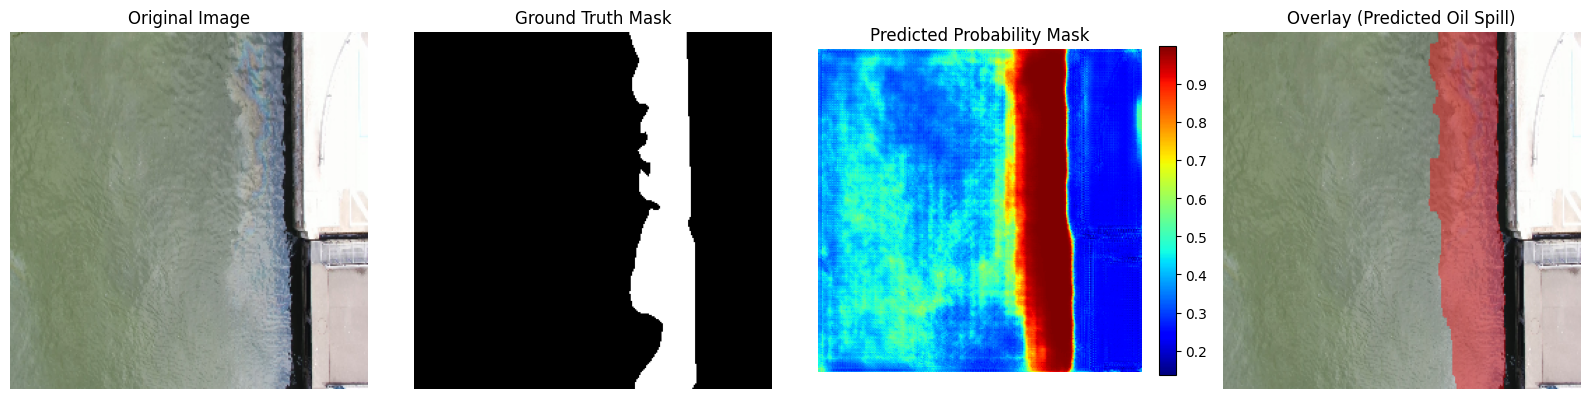

In [34]:
import matplotlib.pyplot as plt

# ---------- Overlay ----------
overlay = img.copy()
alpha = 0.4

oil_pixels = pred_mask == 1
overlay[oil_pixels] = (
    overlay[oil_pixels] * (1 - alpha) +
    np.array([255, 0, 0]) * alpha
).astype(np.uint8)

# ---------- Visualization ----------
plt.figure(figsize=(16, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1, 4, 2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

# Predicted Probability Mask
plt.subplot(1, 4, 3)
plt.imshow(pred_prob, cmap="jet")
plt.title("Predicted Probability Mask")
plt.colorbar(fraction=0.046)
plt.axis("off")

# Overlay Result
plt.subplot(1, 4, 4)
plt.imshow(overlay)
plt.title("Overlay (Predicted Oil Spill)")
plt.axis("off")

plt.tight_layout()
plt.show()


SAVE VISUALS FOR REPORT / DASHBOARD

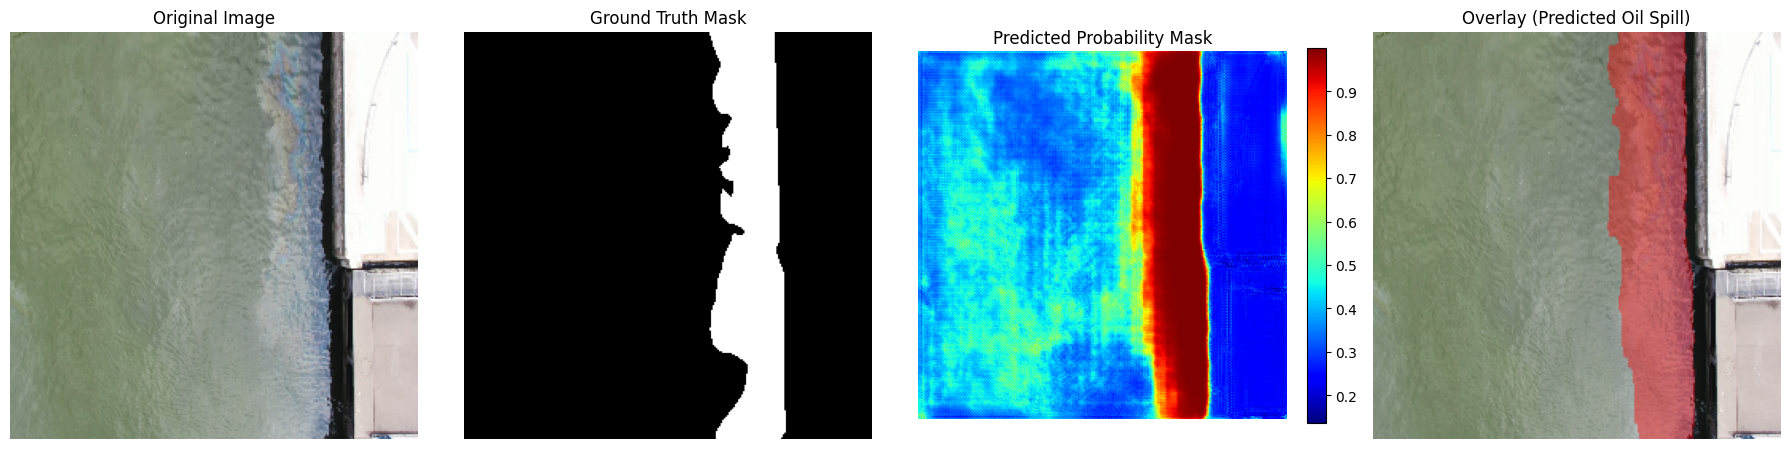

Visualization saved at: outputs/oil_spill_segmentation_result.png


In [35]:
# --------- Create output directory ----------
SAVE_DIR = "outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# --------- Overlay ----------
overlay = img.copy()
alpha = 0.4

oil_pixels = pred_mask == 1
overlay[oil_pixels] = (
    overlay[oil_pixels] * (1 - alpha) +
    np.array([255, 0, 0]) * alpha
).astype(np.uint8)

# --------- Plot ----------
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred_prob, cmap="jet")
plt.title("Predicted Probability Mask")
plt.colorbar(fraction=0.046)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(overlay)
plt.title("Overlay (Predicted Oil Spill)")
plt.axis("off")

plt.tight_layout()

# --------- Save ----------
save_path = os.path.join(SAVE_DIR, "oil_spill_segmentation_result.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Visualization saved at: {save_path}")


Streamlit

In [1]:
!pip install streamlit pyngrok tensorflow opencv-python pillow pandas matplotlib reportlab fpdf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.0 MB/s eta 0:00:00
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=10397f008b750b5394374da16f71000cd2260e63c3d090a74df221f4e7f1e4c3
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [5]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image, ImageDraw
from datetime import datetime
import json
import io
import os
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# ================= SYSTEM CONFIG =================
st.set_page_config(
    page_title="Oil Spill Detection & Monitoring System",
    layout="wide"
)

MODEL_PATH = "/content/unet_oil_spill_best.h5"
STORAGE_DIR = "stored_detections"
os.makedirs(STORAGE_DIR, exist_ok=True)

# ================= LOAD MODEL =================
@st.cache_resource
def load_model():
    return tf.keras.models.load_model(MODEL_PATH, compile=False)

model = load_model()

# ================= SESSION =================
if "history" not in st.session_state:
    st.session_state.history = []

# ================= PREPROCESS =================
def preprocess_image(img, size):
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=0)

# ================= OVERLAY =================
def create_overlay(img, pred_mask, alpha):
    overlay = img.copy()
    oil_pixels = pred_mask == 1
    overlay[oil_pixels] = (
        overlay[oil_pixels] * (1 - alpha) +
        np.array([255, 0, 0]) * alpha
    ).astype(np.uint8)
    return overlay

# ================= DOWNLOAD TRACK (SAFE) =================
def mark_download():
    if st.session_state.history:
        last = st.session_state.history[-1]
        last["Downloaded"] = "YES"
        last["Download Count"] = last.get("Download Count", 0) + 1

# ================= SIDEBAR =================
st.sidebar.title("👤 User Information")
user_name = st.sidebar.text_input("User Name", "Guest User")
user_role = st.sidebar.selectbox("User Role", ["Admin", "Analyst", "Viewer"])

st.sidebar.divider()
st.sidebar.title("⚙️ System Configuration")
threshold = st.sidebar.slider("Prediction Threshold", 0.1, 0.9, 0.5, 0.05)
overlay_alpha = st.sidebar.slider("Overlay Opacity", 0.1, 0.8, 0.4, 0.05)
resize_dim = st.sidebar.selectbox("Inference Resolution", [128, 256, 512], index=1)
sensitivity = st.sidebar.selectbox("Alert Sensitivity", ["Low", "Medium", "High"])
alert_limit = {"Low": 20, "Medium": 10, "High": 5}[sensitivity]

# ================= HEADER =================
st.title("🛢️ Oil Spill Detection & Monitoring Dashboard")
st.caption("UNet | Segmentation | Alerts | Analytics | Audit Trail")
st.divider()

# ================= UPLOAD =================
uploaded_file = st.file_uploader("📤 Upload Satellite Image", type=["jpg", "png", "jpeg"])

if uploaded_file:
    img_np = np.array(Image.open(uploaded_file).convert("RGB"))

    input_tensor = preprocess_image(img_np, resize_dim)
    pred = model.predict(input_tensor, verbose=0)[0, :, :, 0]
    pred_mask = (pred > threshold).astype(np.uint8)

    oil_percent = float((np.sum(pred_mask) / pred_mask.size) * 100)

    pred_mask_vis = cv2.resize(
        pred_mask, (img_np.shape[1], img_np.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    overlay = create_overlay(img_np, pred_mask_vis, overlay_alpha)

    now = datetime.now()
    display_time = now.strftime("%Y-%m-%d %H:%M:%S")
    file_time = now.strftime("%Y%m%d_%H%M%S")

    # ================= SAVE IMAGES =================
    original_path = f"{STORAGE_DIR}/{file_time}_original.jpg"
    mask_path = f"{STORAGE_DIR}/{file_time}_mask.jpg"
    overlay_path = f"{STORAGE_DIR}/{file_time}_overlay.jpg"

    Image.fromarray(img_np).save(original_path)
    Image.fromarray(pred_mask_vis * 255).save(mask_path)
    Image.fromarray(overlay).save(overlay_path)

    # ================= HISTORY RECORD =================
    record = {
        "Timestamp": display_time,
        "User": user_name,
        "Role": user_role,
        "Oil Percentage (%)": round(oil_percent, 2),
        "Threshold": threshold,
        "Resolution": resize_dim,
        "Sensitivity": sensitivity,
        "Alert Triggered": oil_percent >= alert_limit,
        "Downloaded": "NO",
        "Download Count": 0
    }
    st.session_state.history.append(record)

    # ================= VISUALIZATION =================
    st.markdown("## 🖼️ Detection Visualization")
    c1, c2, c3 = st.columns(3)
    c1.image(img_np, "Original Image", use_container_width=True)
    c2.image(pred_mask_vis * 255, "Predicted Mask", use_container_width=True)
    c3.image(overlay, "Overlay Result", use_container_width=True)

    # ================= RESULT =================
    st.markdown("## 🚨 Detection Result")
    if oil_percent >= alert_limit:
        st.error(f"ALERT: Oil Spill Detected ({oil_percent:.2f}%)")
    else:
        st.success(f"No Significant Spill ({oil_percent:.2f}%)")

    # ================= PDF REPORT =================
    pdf_buf = io.BytesIO()
    c = canvas.Canvas(pdf_buf, pagesize=A4)
    width, height = A4

    c.setFont("Helvetica-Bold", 18)
    c.drawCentredString(width / 2, height - 50, "Oil Spill Detection Report")

    c.setFont("Helvetica", 11)
    y = height - 90
    for k, v in record.items():
        c.drawString(50, y, f"{k}: {v}")
        y -= 16

    c.drawImage(original_path, 50, 360, 240, 180)
    c.drawImage(mask_path, 320, 360, 240, 180)
    c.drawImage(overlay_path, 50, 140, 510, 200)
    c.showPage()
    c.save()

    # ================= JPG REPORT =================
    report_img = Image.new("RGB", (1200, 1600), "white")
    d = ImageDraw.Draw(report_img)

    d.text((380, 20), "Oil Spill Detection Report", fill=(0, 0, 0))
    y = 80
    for k, v in record.items():
        d.text((40, y), f"{k}: {v}", fill=(0, 0, 0))
        y += 30

    report_img.paste(Image.open(original_path).resize((350, 250)), (40, y + 20))
    report_img.paste(Image.open(mask_path).resize((350, 250)), (420, y + 20))
    report_img.paste(Image.open(overlay_path).resize((740, 350)), (40, y + 300))

    jpg_buf = io.BytesIO()
    report_img.save(jpg_buf, format="JPEG", quality=95)

    # ================= DOWNLOAD =================
    st.markdown("## 📥 Download Full Report")
    c1, c2, c3 = st.columns(3)

    c1.download_button("📄 PDF Report", pdf_buf.getvalue(),
                       f"Oil_Report_{file_time}.pdf",
                       "application/pdf", on_click=mark_download)

    c2.download_button("🖼️ JPG Report", jpg_buf.getvalue(),
                       f"Oil_Report_{file_time}.jpg",
                       "image/jpeg", on_click=mark_download)

    c3.download_button("📦 JSON Report",
                       json.dumps(record, indent=4),
                       f"Oil_Report_{file_time}.json",
                       "application/json", on_click=mark_download)

    # ================= API ACCESS =================
    st.markdown("## 🌐 Real-Time API Access")
    st.code(json.dumps(record, indent=4), language="json")
    st.caption("API Endpoint: /api/latest (JSON response for monitoring systems)")

    st.markdown("## 🕒 Detection History")
    st.table(st.session_state.history)

else:
    st.info("Upload image to start detection")

st.divider()
st.caption("Oil Spill Monitoring Web Application")


Overwriting app.py


In [3]:
!streamlit run app.py &>/content/logs.txt &


In [4]:
from pyngrok import ngrok

ngrok.set_auth_token("37O2dCF7E0SQBvs1FyZcwbqGJuF_4L7FbVc7cmZppKaAuj5m")

public_url = ngrok.connect(8501)
print("OPEN THIS URL 👉", public_url)

OPEN THIS URL 👉 NgrokTunnel: "https://many-synoecious-mavis.ngrok-free.dev" -> "http://localhost:8501"
